In [1]:
import torch
import torchvision
import os, sys, matplotlib.pyplot as plt, numpy as np
%matplotlib inline
sys.path.append('../src/')
from vae import VAE
import cv2

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 64
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 42
torch.manual_seed(random_seed)
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data/', train=True, download=False,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ])),
  batch_size=batch_size_train, shuffle=True, pin_memory=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data/', train=False, download=False,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ])),
  batch_size=batch_size_test, shuffle=False, pin_memory=True)

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

0 tensor(7)
784


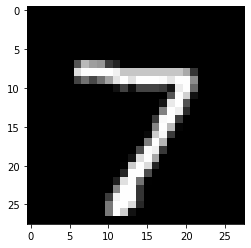

In [5]:
print(batch_idx, example_targets[0])
print(example_data.numpy()[0][0].size)
plt.imshow(example_data.numpy()[0][0], cmap='gray')

In [6]:
np.min(example_data.numpy()[0][0]), np.max(example_data.numpy()[0][0])

(0.0, 1.0)

In [7]:
layers = [256, 64, 16]
epochs = [70, 71]
# regularization = ('weight_decay', 0.05)
loss_threshold = 0.01

In [8]:
model = VAE(device)

In [9]:
train_err, test_err = model.train(train_loader, epochs=epochs, test_data=test_loader, loss_threshold=loss_threshold)

72it [22:25, 19.66s/it]                        


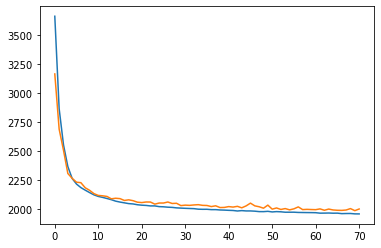

In [10]:
plt.plot(train_err)
plt.plot(test_err)

In [11]:
ex = model.encode(test_loader)
# ex = ex[:10,:, :1,:]
ex.shape

torch.Size([10000, 2, 100])

In [12]:
dx = model.decode(ex).cpu().numpy()

In [13]:
dx.shape

(10000, 1, 28, 28)

In [14]:
for data, _ in test_loader:
    test_images = data.cpu().numpy()
    break

In [15]:
test_images.shape

(64, 1, 28, 28)

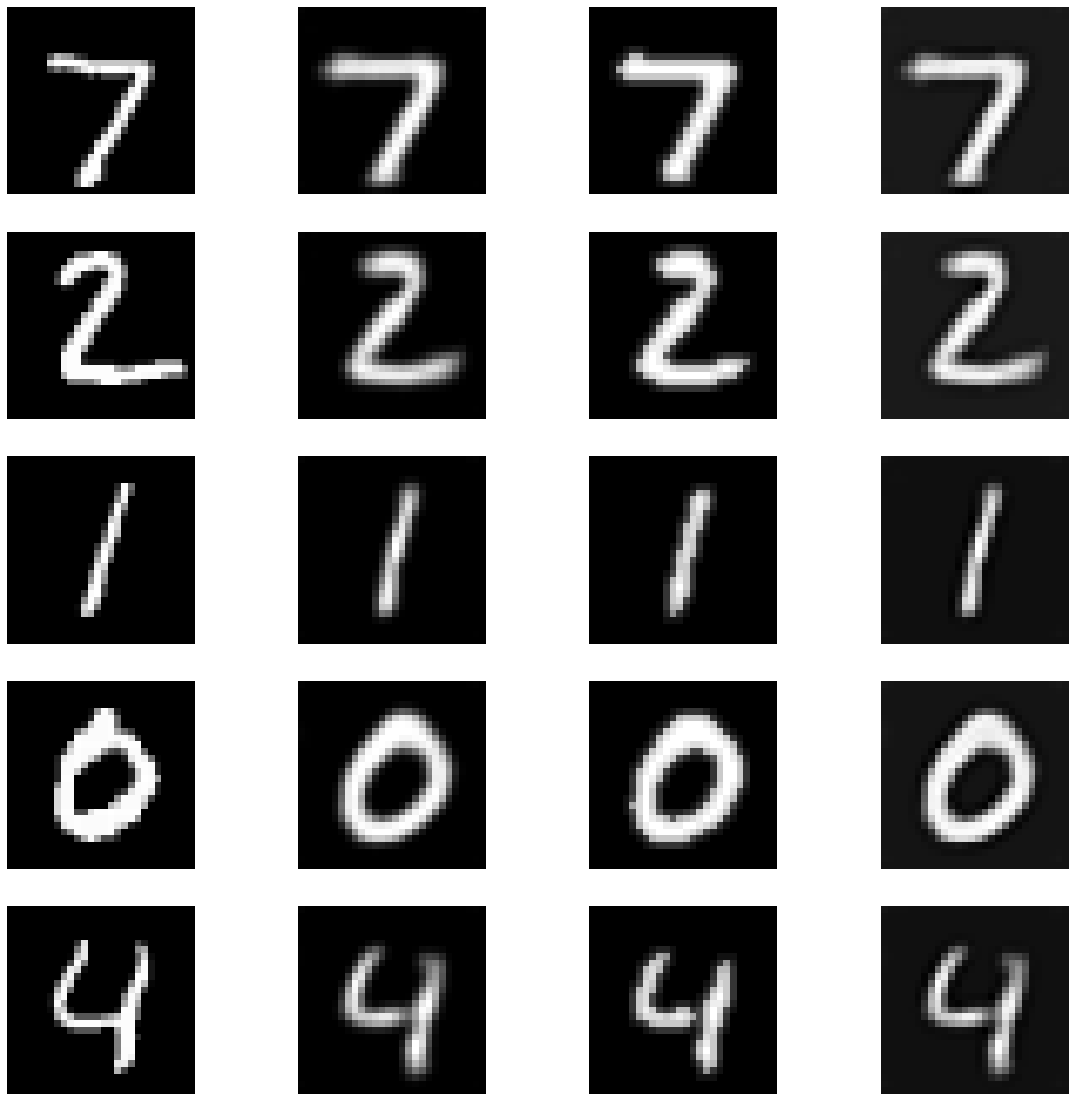

In [16]:
rows = 5
cols = 4
fig = plt.figure(figsize=[20,20])
for n in range(rows):
    fig.add_subplot(rows, cols, cols*n+1)
    plt.axis('off')
    plt.imshow(test_images[n, 0], cmap='gray')
    fig.add_subplot(rows, cols, cols*n+2)
    plt.axis('off')
    img = dx[n, 0]
    plt.imshow(img, cmap='gray')
    
    fig.add_subplot(rows, cols, cols*n+3)
    plt.axis('off')
    
    t, img = cv2.threshold(img,0.4,1,cv2.THRESH_BINARY)
        
    surr = 0.07
    slf = 0.44
    kernel = np.array([[surr,surr,surr], [surr,slf,surr], [surr,surr,surr]])
    img = cv2.filter2D(img, -1, kernel)
    
#     kernel = np.ones((1, 1), np.uint8)
#     img = cv2.erode(img, kernel, iterations=10)
#     img = cv2.dilate(img, kernel, iterations=1)

    plt.imshow(img, cmap='gray')
    
    img = dx[n, 0]
    fig.add_subplot(rows, cols, cols*n+4)
    plt.axis('off')
    
    surr = -0.1
    slf = 1.9
    kernel = np.array([[surr,surr,surr], [surr,slf,surr], [surr,surr,surr]])
    img = cv2.filter2D(img, -1, kernel)
    plt.imshow(img, cmap='gray')

plt.show()

In [17]:
for name, param in model.model.named_parameters():
#     print(name)
    if name == "lastconv.weight" or name == "lastconv.bias":
        print(param)

Parameter containing:
tensor([[[[0.0009, 0.0620, 0.0496],
          [0.0898, 0.3995, 0.1831],
          [0.0153, 0.1649, 0.0221]]]], device='cuda:2', requires_grad=True)


In [18]:
dr = model.decode(torch.randn([25, 2, 100])).cpu()

generated


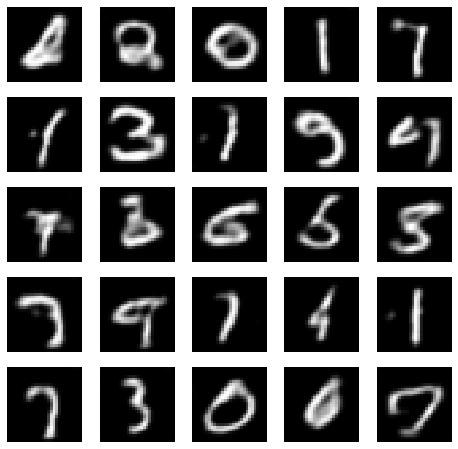

test dataset


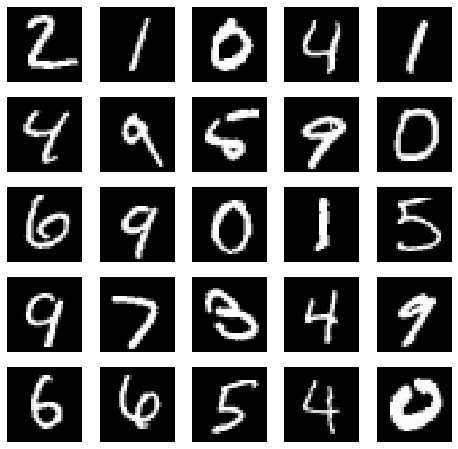

In [35]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 5
print("generated:")
for i in range(1, columns*rows +1):
    img = dr[i-1, 0].reshape([28,28])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
# plt.savefig("test.png", bbox_inches='tight')
plt.show()

print("test dataset:")
fig=plt.figure(figsize=(8, 8))
for i in range(1, columns*rows +1):
    img = test_images[i, 0]
#     img = dr[i-1, 0].reshape([28,28])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
# plt.savefig("test.png", bbox_inches='tight')
plt.show()

In [20]:
from torchvision.utils import save_image

save_image(dr[:25], "vae.png", nrow=5, normalize=True)